# Convolutional Neural Nets

We'll explore the different layers that make up a Convolutional Neural Network.

Code reference:
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [5]:
import keras
from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.datasets import mnist

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [22]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()



In [27]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [29]:
# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


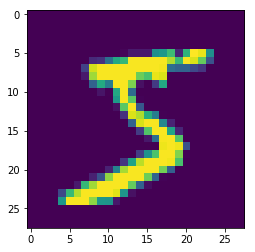

In [25]:
plt.imshow(X_train[0])
print(y_train[0])

## Reshaping image data

The first difference with MLP is that we have to treat the images as 2D images (or 2D images with RGB channels).

For MLP, we flatten the input to a vector. 

For CNNs, the input is expected to be processed as (rows, cols, channels) or (channels, rows, cols)

In [30]:
img_rows = 28
img_cols = 28

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    K.image_data_format()

In [31]:
 K.image_data_format()

'channels_last'

In [32]:
X_train.shape

(60000, 28, 28, 1)

In [33]:
input_shape

(28, 28, 1)

## Model

In [34]:
model = Sequential()

# filters = 32 (output depth, number of sets of filters)
# kernel_size = 3, 3 (size of the filter)
# strides = 1, 1 (how much to slide the window)
# padding = 'valid' (no padding). ('same' = padding)
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras import optimizers

# losses: https://keras.io/losses/
# multi-class classification - categorical_crossentropy
# binary classification - binary_crossentropy
# regression - mean_squared_error

# optimisers: https://keras.io/optimizers/
# SGD - simple (good for fine tuning with lr=very small)
# RMSProp - apparently good for RNNs
# Adam - more black box but popular!
# Adagrad - smaller updates for more frequently updated weights

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# inspect weights before training. See how
# they are randomly initialised!
for layer in model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    print(g)
    print(h)

{'name': 'conv2d_1', 'trainable': True, 'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[[ 0.14113684, -0.11764049,  0.06494218,  0.05986044,
          -0.14181189, -0.03348093, -0.10424963, -0.10664333,
          -0.10048977, -0.06299061, -0.10053846,  0.09345746,
           0.00092174, -0.02446293,  0.11413531, -0.04758857,
          -0.14075996,  0.04174687,  0.08749041,  0.08250149,
          -0.03173411, -0.08323589, -0.08082453,  0.12619053,
          -0.02

In [13]:
# Tensorboard for learning curve
# Early stopping (to avoid overfitting)
# Model checkpoint (to save model periodically)

from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [14]:
tensorboard = TensorBoard(log_dir='./logs/mnist_cnn')

# stop training early if val_loss increases for 2 consecutive epochs
# this way we don't train forever and overfit
earlystop = EarlyStopping(patience=2)

checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

In [15]:
model.fit(X_train, y_train, batch_size=128, epochs=20,
          verbose=1, callbacks=[tensorboard, earlystop, checkpoint],
          validation_split=0.25) # set aside 25% for validation

Train on 45000 samples, validate on 15000 samples
Epoch 1/20
45000/45000 [==============================] - 57s 1ms/step - loss: 0.8625 - acc: 0.7748 - val_loss: 0.4269 - val_acc: 0.8714
Epoch 2/20
45000/45000 [==============================] - 34s 750us/step - loss: 0.3045 - acc: 0.9088 - val_loss: 0.2958 - val_acc: 0.9063
Epoch 3/20
45000/45000 [==============================] - 34s 751us/step - loss: 0.2433 - acc: 0.9272 - val_loss: 0.2480 - val_acc: 0.9244
Epoch 4/20
45000/45000 [==============================] - 33s 740us/step - loss: 0.2046 - acc: 0.9397 - val_loss: 0.2095 - val_acc: 0.9355
Epoch 5/20
45000/45000 [==============================] - 35s 788us/step - loss: 0.1762 - acc: 0.9478 - val_loss: 0.1680 - val_acc: 0.9504
Epoch 6/20
45000/45000 [==============================] - 36s 798us/step - loss: 0.1543 - acc: 0.9538 - val_loss: 0.1564 - val_acc: 0.9533
Epoch 7/20
45000/45000 [==============================] - 35s 785us/step - loss: 0.1369 - acc: 0.9594 - val_loss: 0.17

In [16]:
# view saved weights
!dir *.hdf5

 Volume in drive C is Windows
 Volume Serial Number is AEA3-B078

 Directory of C:\Users\Anirban\Desktop\NUS-Machine Learning For Data Science\Week 4 Codes\CNN 2

16/12/2018  09:20 PM         9,626,952 weights.01-0.33.hdf5
22/12/2018  09:12 AM         9,626,952 weights.01-0.43.hdf5
16/12/2018  09:21 PM         9,626,952 weights.02-0.27.hdf5
22/12/2018  09:13 AM         9,626,952 weights.02-0.30.hdf5
16/12/2018  09:21 PM         9,626,952 weights.03-0.24.hdf5
22/12/2018  09:13 AM         9,626,952 weights.03-0.25.hdf5
16/12/2018  09:22 PM         9,626,952 weights.04-0.19.hdf5
22/12/2018  09:14 AM         9,626,952 weights.04-0.21.hdf5
22/12/2018  09:14 AM         9,626,952 weights.05-0.17.hdf5
16/12/2018  09:22 PM         9,626,952 weights.05-0.18.hdf5
16/12/2018  09:23 PM         9,626,952 weights.06-0.15.hdf5
22/12/2018  09:15 AM         9,626,952 weights.06-0.16.hdf5
16/12/2018  09:24 PM         9,626,952 weights.07-0.14.hdf5
22/12/2018  09:16 AM         9,626,952 weights.07-0.17.hd

In [17]:
# Load weights with lowest validation loss
from keras.models import load_model

# your actual filename may differ
best_model = load_model('./weights.04-0.19.hdf5')
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


## Visualising layers

The following code can be used to visualise 

In [18]:
from keras.models import Model
def visualize(model, data, layer_index):

    # intermediate model with input and nth layer layer only
    int_model = Model(inputs=model.input,
                      outputs=model.layers[layer_index].output)

    output = int_model.predict(np.expand_dims(data, axis=0))[0]
    
    # first 10 feature maps
    fig, axes = plt.subplots(nrows=2, ncols=5)
    axes = axes.flatten()

    for i in range(len(axes)):
        axes[i].imshow(output[:, :, i])

# visualize(model, data=X_test[0], layer_index=0)
# use model.layers to view layers and get index

In [19]:
best_model.layers

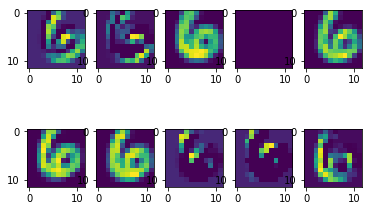

In [20]:
visualize(best_model, data=X_test[100], layer_index=2)

## PREDICT CLASSES

In [21]:
pred = best_model.predict_classes(X_test)
pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [22]:
# pred is label encoded
pred.shape

(10000,)

In [23]:
# y_test is still one-hot encoded, need to get label-encoded version
y_test.shape

(10000, 10)

In [24]:
# label encoded version
y_test.argmax(axis=1)

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [25]:
# Examine incorrect ones

# find test with incorrect prediction
# np.argmax(y_test, axis=1) != pred
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test.argmax(axis=1), pred))

# number of incorrect ones
print((np.argmax(y_test, axis=1) != pred).sum())

0.948
520


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test.argmax(axis=1), pred))
print(classification_report(y_test.argmax(axis=1), pred))

[[ 937    0    1    3    0   15   17    4    2    1]
 [   0 1118    3    2    0    1    4    1    6    0]
 [   5    1  969   24    5    3    6    9    9    1]
 [   0    1    6  975    2    9    0    7    4    6]
 [   0    0    7    0  952    0    5    2    1   15]
 [   5    1    0   25    3  835   14    2    1    6]
 [   4    3    1    2   10    9  926    2    1    0]
 [   0    5   12   12    8    2    0  973    0   16]
 [   5    3    0   32   12   26   13   11  861   11]
 [   3    6    1   18   29    7    1   10    0  934]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.94      0.95      1032
           3       0.89      0.97      0.93      1010
           4       0.93      0.97      0.95       982
           5       0.92      0.94      0.93       892
           6       0.94      0.97      0.95       958
           7       0.95      0.95   

## Examining Model Weights

In [27]:
# How to print layer info
# https://github.com/keras-team/keras/issues/91

for layer in best_model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    print(g)
    print(h)

{'name': 'conv2d_1', 'trainable': True, 'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[[ 0.01227896,  0.09714822, -0.1416605 , -0.04538184,
           0.16170065, -0.01948132, -0.01394858,  0.10749456,
           0.02989038, -0.12465435,  0.16903192,  0.22261076,
           0.02696884,  0.08321783,  0.13848722, -0.01747857,
          -0.06300803,  0.11161458,  0.03179993,  0.14308563,
          -0.07145189,  0.12686664,  0.00194737,  0.05548962,
           0.08

{'name': 'dense_2', 'trainable': True, 'units': 10, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[-0.1738229 , -0.05999041, -0.04496974, ...,  0.19083297,
        -0.09035675, -0.04674414],
       [-0.02927443,  0.1692089 ,  0.0982643 , ..., -0.19610018,
        -0.20497148, -0.20859772],
       [ 0.06653865,  0.21224943,  0.23595984, ...,  0.20027272,
         0.02723352, -0.12066386],
       ...,
       [ 0.09470124,  0.10289106,  0.15395218, ..., -0.04886428,
         0.16498587,  0.05892156],
       [-0.02544912,  0.19105616, -0.17345926, ...,  0.05901008,
        -0.02641751,  0.22863384],
       [-0.04049615, -0.12492936, -0.12587588, ..., -0

In [28]:
l = best_model.layers[0]
l.get_config()

{'name': 'conv2d_1',
 'trainable': True,
 'batch_input_shape': (None, 28, 28, 1),
 'dtype': 'float32',
 'filters': 32,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [29]:
# How to get the weights for a given Conv Layer
w = np.array(l.get_weights())

print('bias', w[1].shape, w[1])
print('filters/kernels', w[0].shape, w[0])

bias (32,) [-6.44292962e-03 -1.01794845e-04  6.84266997e-05  7.37458747e-03
  2.07505473e-05  4.51530330e-03  2.87825316e-02  4.98737535e-03
  1.48957683e-04 -5.33284656e-05 -4.85457189e-04 -5.00684720e-04
  3.75397736e-03  2.08997112e-02  1.68671971e-03  2.88217841e-03
 -5.21893962e-05 -3.86640517e-04 -2.51241669e-04 -2.81577057e-04
 -5.75842615e-03 -1.63428340e-05 -1.02658826e-03  5.65173710e-03
 -4.05391074e-06  3.21206683e-03 -1.02823993e-04  2.25987118e-02
 -1.41451921e-04  4.31281254e-02 -2.96678947e-04  1.49602229e-02]
filters/kernels (3, 3, 1, 32) [[[[ 0.01227896  0.09714822 -0.1416605  -0.04538184  0.16170065
    -0.01948132 -0.01394858  0.10749456  0.02989038 -0.12465435
     0.16903192  0.22261076  0.02696884  0.08321783  0.13848722
    -0.01747857 -0.06300803  0.11161458  0.03179993  0.14308563
    -0.07145189  0.12686664  0.00194737  0.05548962  0.08460376
    -0.06026105  0.03567543 -0.09896515  0.1094444   0.10942791
     0.11968002  0.09304192]]

  [[-0.02441323  0.1667

In [30]:
# weights for Conv layer 2

l = best_model.layers[1]
l.get_config()

# filters (kernels) for Conv layer 1
w = np.array(l.get_weights())

print('bias', w[1].shape, w[1])
print('filters/kernels', w[0].shape, w[0])

bias (64,) [ 0.02909077  0.00955908  0.00175155 -0.00544724  0.00720261  0.01091009
  0.00274784  0.01188606 -0.0052869   0.02165866  0.00270105  0.00445958
 -0.00837108  0.01373327  0.00473995  0.00489869  0.00461408  0.00344104
 -0.00268086  0.02709774  0.00319914 -0.00579575  0.0143681   0.00463528
 -0.01153043 -0.00100785 -0.0084053   0.01876679  0.01267664 -0.0016611
  0.00616621 -0.00017827  0.00560669 -0.00713376  0.0053732  -0.00150878
 -0.00830248  0.0043639   0.01483833  0.01071494  0.01478551  0.01621326
  0.00765439 -0.00512389  0.00868643 -0.00366807 -0.0037813   0.0033538
  0.00575973  0.02378697  0.00614497  0.00933234 -0.00129687  0.00151763
 -0.00834245 -0.00305887  0.01605555 -0.00500758  0.00105473 -0.00313228
  0.01615624 -0.00175586  0.00741584  0.02821036]
filters/kernels (3, 3, 32, 64) [[[[-0.01815207 -0.0454562   0.03883698 ...  0.02062566  0.00310209
    -0.04074128]
   [ 0.05526897  0.06239812 -0.00015098 ... -0.00893708  0.02299826
    -0.07346117]
   [-0.078